In [1]:
import os 
from locscale.include.emmer.ndimage.map_utils import load_map, save_as_mrc 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

low_bfactor_map_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/study_isotropic_assumption/emmap_3061_simmap_biso_20.mrc"
high_bfactor_map_path = "/home/abharadwaj1/papers/elife_paper/figure_information/data/study_isotropic_assumption/emmap_3061_simmap_biso_200.mrc"

low_bfactor_map, apix = load_map(low_bfactor_map_path)
high_bfactor_map = load_map(high_bfactor_map_path)[0]

Text(0.5, 1.0, 'High B-factor')

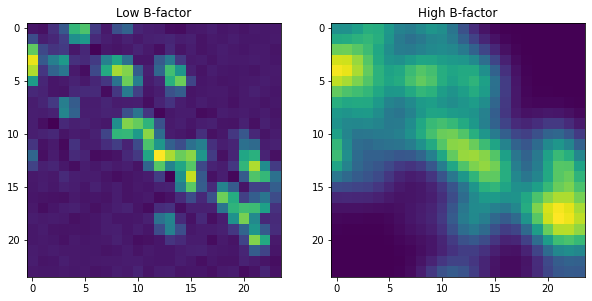

In [2]:
from locscale.include.emmer.ndimage.map_utils import extract_window
dims = low_bfactor_map.shape
center = np.array(dims) // 2
window_size = int(round(25 / apix))

cropped_low_bfactor_map = extract_window(low_bfactor_map, center, window_size)
cropped_high_bfactor_map = extract_window(high_bfactor_map, center, window_size)

# plot the center slice of the cropped maps
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
slice_idx = window_size // 2
ax[0].imshow(cropped_low_bfactor_map[slice_idx])
ax[1].imshow(cropped_high_bfactor_map[slice_idx])
ax[0].set_title("Low B-factor")
ax[1].set_title("High B-factor")


In [3]:
central_value = cropped_low_bfactor_map[slice_idx, slice_idx, slice_idx]
print("Central value of low B-factor map: {}".format(central_value))
print("Central value of high B-factor map: {}".format(cropped_high_bfactor_map[slice_idx, slice_idx, slice_idx]))

Central value of low B-factor map: 0.6525951027870178
Central value of high B-factor map: 0.1694246083498001


Text(0.5, 1.0, 'High B-factor')

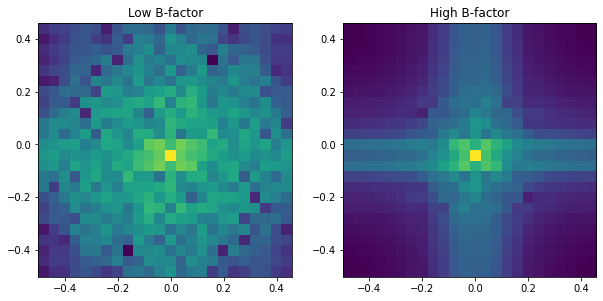

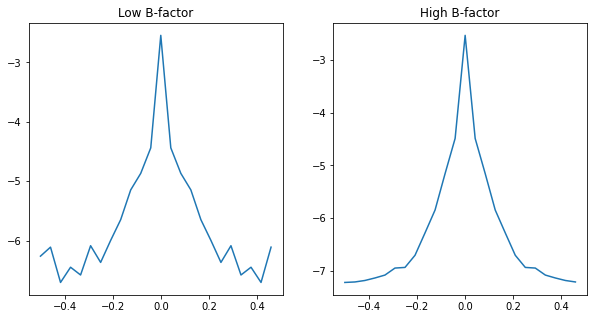

In [4]:
# get structure factors 
# F_u is the structure factor of the high B-factor map and F_p is the structure factor of the low B-factor map

fft_low_bfactor_map = np.fft.fftn(cropped_low_bfactor_map)
fft_high_bfactor_map = np.fft.fftn(cropped_high_bfactor_map)

# fftshift the structure factors
fft_low_bfactor_map = np.fft.fftshift(fft_low_bfactor_map)
fft_high_bfactor_map = np.fft.fftshift(fft_high_bfactor_map)

# normalize the structure factors by the shape of the map
fft_low_bfactor_map_norm = fft_low_bfactor_map / np.prod(cropped_low_bfactor_map.shape)
fft_high_bfactor_map_norm = fft_high_bfactor_map / np.prod(cropped_high_bfactor_map.shape)

freqs = np.fft.fftfreq(cropped_low_bfactor_map.shape[0], d=apix)
freqs = np.fft.fftshift(freqs)

# plot the structure factor magnitudes
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(np.log(np.abs(fft_low_bfactor_map[slice_idx])), extent=[freqs[0], freqs[-1], freqs[0], freqs[-1]])
ax[1].imshow(np.log(np.abs(fft_high_bfactor_map[slice_idx])), extent=[freqs[0], freqs[-1], freqs[0], freqs[-1]])

# set the x and y ticks to match the max and min frequencies


ax[0].set_title("Low B-factor")
ax[1].set_title("High B-factor")


fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(freqs, np.log(np.abs(fft_low_bfactor_map_norm[slice_idx, slice_idx])))
ax[1].plot(freqs, np.log(np.abs(fft_high_bfactor_map_norm[slice_idx, slice_idx])))

ax[0].set_title("Low B-factor")
ax[1].set_title("High B-factor")


In [5]:
zero_freq_value_low_bfactor = fft_low_bfactor_map_norm[slice_idx, slice_idx, slice_idx] 
zero_freq_value_high_bfactor = fft_high_bfactor_map_norm[slice_idx, slice_idx, slice_idx] 

print("Zero frequency value of low B-factor map: {}".format(zero_freq_value_low_bfactor))
print("Zero frequency value of high B-factor map: {}".format(zero_freq_value_high_bfactor))

mean_value_low_bfactor_map = cropped_low_bfactor_map.mean()
mean_value_high_bfactor_map = cropped_high_bfactor_map.mean()

print("Mean value of low B-factor map: {}".format(mean_value_low_bfactor_map))
print("Mean value of high B-factor map: {}".format(mean_value_high_bfactor_map))



Zero frequency value of low B-factor map: (0.07854840639317923+0j)
Zero frequency value of high B-factor map: (0.0790609931518306+0j)
Mean value of low B-factor map: 0.07854841649532318
Mean value of high B-factor map: 0.07906099408864975


Text(0, 0.5, 'Amplitude variance')

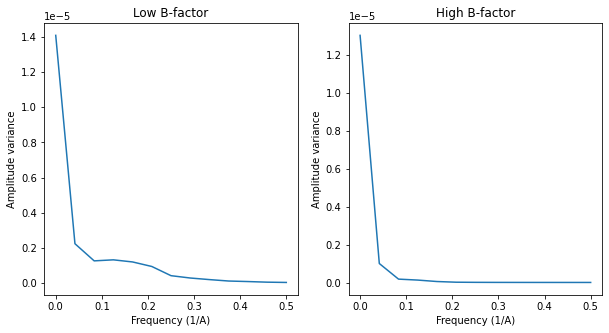

In [6]:
# get the variance 
def calculate_shell_variance(shell1):
    '''
    Calculate the variance of a shell of structure factors
    '''
    variance = np.var(np.abs(shell1))
    return variance

def calculate_amplitude_variance(map1):
    fft_map1 = np.fft.fftn(map1)
    fft_map1 = np.fft.fftshift(fft_map1)
    fft_map1_norm = fft_map1 / np.prod(map1.shape)
    freqs = np.fft.fftfreq(map1.shape[0], d=apix)
    freqs = np.fft.fftshift(freqs)
    freqs_abs = np.abs(freqs)
    # get the shell values
    frequencies_unique = np.unique(freqs_abs)
    shell_variances_map1 = []
    shell_values_map1 = []
    for frequency in frequencies_unique:
        shell_values = fft_map1_norm[freqs_abs == frequency]
        shell_values_map1.append(shell_values.flatten())
        shell_variances_map1.append(calculate_shell_variance(shell_values))
    shell_variances_map1 = np.array(shell_variances_map1)

    return frequencies_unique, shell_variances_map1, shell_values_map1

frequencies_unique_low_bfactor, shell_variances_low_bfactor, shell_values_low_bfactor = calculate_amplitude_variance(cropped_low_bfactor_map)
frequencies_unique_high_bfactor, shell_variances_high_bfactor, shell_values_high_bfactor = calculate_amplitude_variance(cropped_high_bfactor_map)

# plot the shell variances
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(frequencies_unique_low_bfactor, shell_variances_low_bfactor)
ax[1].plot(frequencies_unique_high_bfactor, shell_variances_high_bfactor)
ax[0].set_title("Low B-factor")
ax[1].set_title("High B-factor")
ax[0].set_xlabel("Frequency (1/A)")
ax[1].set_xlabel("Frequency (1/A)")
ax[0].set_ylabel("Amplitude variance")
ax[1].set_ylabel("Amplitude variance")





In [7]:
shell_values_low_bfactor[0].shape

(576,)

In [8]:
np.abs(shell_values_low_bfactor[0])

array([8.92750959e-05, 1.26372600e-04, 1.43474603e-04, 1.92721476e-04,
       2.37432542e-04, 1.95630256e-04, 5.77491466e-05, 2.20202638e-04,
       4.82848512e-04, 4.64112428e-04, 4.43271835e-04, 2.30485946e-04,
       7.50409724e-04, 2.30485946e-04, 4.43271835e-04, 4.64112428e-04,
       4.82848512e-04, 2.20202638e-04, 5.77491466e-05, 1.95630256e-04,
       2.37432542e-04, 1.92721476e-04, 1.43474603e-04, 1.26372600e-04,
       4.98697711e-05, 8.54286001e-05, 1.15276540e-04, 2.14068584e-04,
       2.46441731e-04, 1.32965688e-04, 9.93851307e-05, 2.83360204e-04,
       1.17868318e-04, 8.99994845e-04, 7.17317608e-04, 4.14093664e-04,
       1.64693954e-03, 9.57166466e-04, 4.16441233e-04, 6.58435344e-04,
       5.56722486e-04, 1.53150046e-04, 1.03473172e-04, 1.75152570e-04,
       2.44567227e-04, 1.87021987e-04, 9.56067620e-05, 8.87634919e-05,
       7.98188147e-05, 1.18266002e-04, 1.63416229e-04, 2.41941339e-04,
       2.47066034e-04, 3.09021232e-04, 2.27299206e-04, 2.66181870e-04,
      

[ 0  1  2  4  5  6  8  9 10 12]
Selected frequencies for low B-factor map: [0.         0.04166667 0.08333333 0.16666667 0.20833333 0.25
 0.33333333 0.375      0.41666667 0.5       ]
Number of samples for each frequency: 100
Number of frequencies: 10


Text(0, 0.5, 'Amplitude')

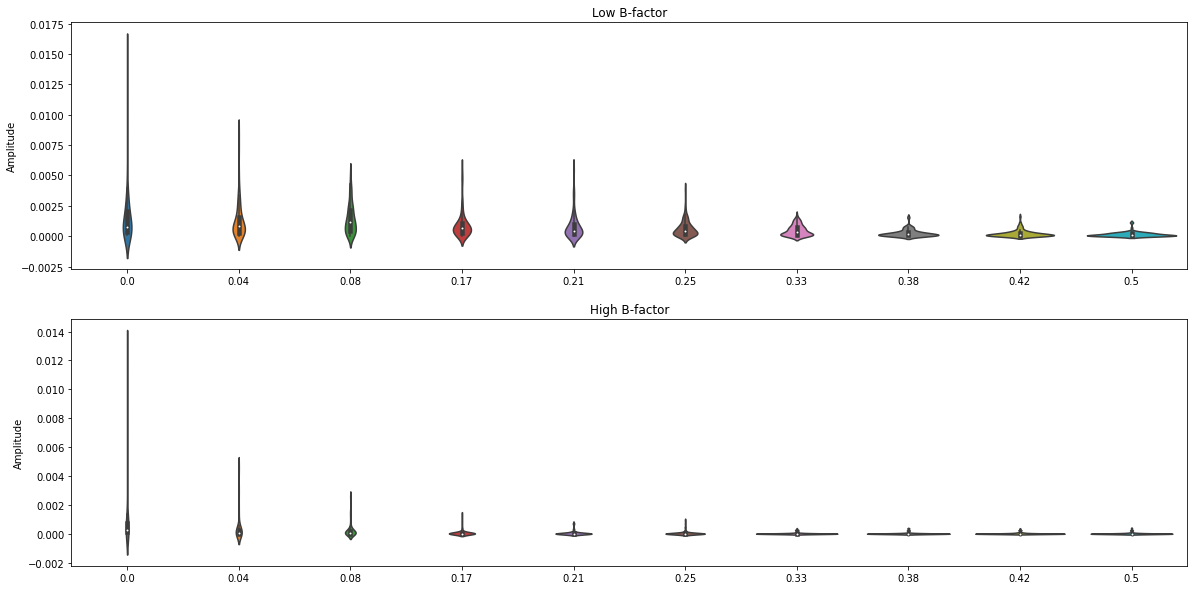

In [9]:
# plot distribution of structure factor values for ten frequency shells
sample_size = 100 
selected_frequency_index = np.linspace(0, len(frequencies_unique_low_bfactor) - 1, 10).astype(int)
print(selected_frequency_index)
ten_freqs_low_bfactor = frequencies_unique_low_bfactor[selected_frequency_index]
ten_freqs_high_bfactor = frequencies_unique_high_bfactor[selected_frequency_index]

print("Selected frequencies for low B-factor map: {}".format(ten_freqs_low_bfactor))

shell_values_selected_freqs_low_bfactor = []
shell_values_selected_freqs_high_bfactor = []
for i in selected_frequency_index:
    shell_values_low_bfactor_index_i = shell_values_low_bfactor[i]
    shell_values_high_bfactor_index_i = shell_values_high_bfactor[i]

    shell_vals_low_bfactor_sample = np.random.choice(shell_values_low_bfactor_index_i, size=sample_size)
    shell_vals_high_bfactor_sample = np.random.choice(shell_values_high_bfactor_index_i, size=sample_size)

    abs_shell_vals_low_bfactor_sample = np.abs(shell_vals_low_bfactor_sample)
    abs_shell_vals_high_bfactor_sample = np.abs(shell_vals_high_bfactor_sample)
    
    shell_values_selected_freqs_low_bfactor.append(abs_shell_vals_low_bfactor_sample)
    shell_values_selected_freqs_high_bfactor.append(abs_shell_vals_high_bfactor_sample)

print("Number of samples for each frequency: {}".format(len(shell_values_selected_freqs_low_bfactor[0])))
print("Number of frequencies: {}".format(len(shell_values_selected_freqs_low_bfactor)))
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sns.violinplot(shell_values_selected_freqs_low_bfactor, ax=ax[0])
sns.violinplot(shell_values_selected_freqs_high_bfactor, ax=ax[1])

# set the xticks
xticks = []
for i in range(len(shell_values_selected_freqs_low_bfactor)):
    xticks.append("{}".format(round(ten_freqs_low_bfactor[i], 2)))
ax[0].set_xticklabels(xticks)
ax[1].set_xticklabels(xticks)

ax[0].set_title("Low B-factor")
ax[1].set_title("High B-factor")

ax[0].set_ylabel("Amplitude")
ax[1].set_ylabel("Amplitude")

                                                    



In [10]:
# extract window from a different part of the high B-factor map
new_center = np.array([115, 116, 120])
new_window_size = int(round(25 / apix))

cropped_low_bfactor_map_new_center = extract_window(low_bfactor_map, new_center, new_window_size)

# plot the center slice of the cropped maps
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
slice_idx = new_window_size // 2
ax[0].imshow(cropped_low_bfactor_map_new_center[slice_idx])
ax[1].imshow(cropped_low_bfactor_map[slice_idx])
ax[0].set_title("New center")
ax[1].set_title("Original center")



Text(0.5, 1.0, 'Original center')

In [11]:
new_reference = cropped_low_bfactor_map_new_center
target = cropped_high_bfactor_map
original_reference = cropped_low_bfactor_map



In [12]:

def invert_intensities(cubes):
    cubes_inverted = np.empty_like(cubes)
    for cube in cubes:
        maxvalue, minvalue = np.max(cube), np.min(cube)
        cube_inverted = maxvalue - cube + minvalue
        cubes_inverted = np.append(cubes_inverted, cube_inverted, axis=0)
    return cubes_inverted

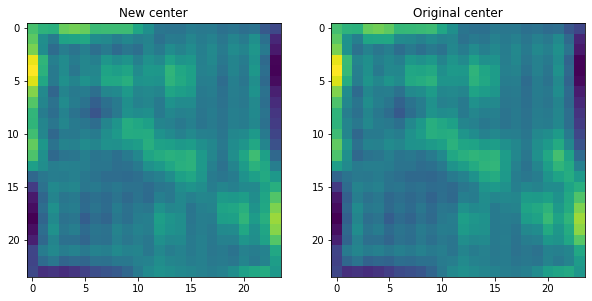

In [63]:
from locscale.include.emmer.ndimage.map_tools import apply_radial_profile
scaled_target_original_reference = apply_radial_profile(target, reference_map=original_reference)
scaled_target_new_reference = apply_radial_profile(target, reference_map=new_reference)

# plot the center slice of the scaled maps
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
slice_idx = new_window_size // 2
ax[0].imshow(scaled_target_new_reference[slice_idx])
ax[1].imshow(scaled_target_original_reference[slice_idx])
ax[0].set_title("New center")
ax[1].set_title("Original center")

output_folder = os.path.dirname(low_bfactor_map_path)
save_as_mrc(scaled_target_new_reference, os.path.join(output_folder, "scaled_target_new_reference.mrc"), apix=apix)
save_as_mrc(scaled_target_original_reference, os.path.join(output_folder, "scaled_target_original_reference.mrc"), apix=apix)
save_as_mrc(cropped_low_bfactor_map_new_center, os.path.join(output_folder, "cropped_low_bfactor_map_new_center.mrc"), apix=apix)
save_as_mrc(cropped_low_bfactor_map, os.path.join(output_folder, "cropped_low_bfactor_map.mrc"), apix=apix)
save_as_mrc(cropped_high_bfactor_map, os.path.join(output_folder, "cropped_high_bfactor_map.mrc"), apix=apix)
save_as_mrc(new_reference, os.path.join(output_folder, "new_reference.mrc"), apix=apix)
save_as_mrc(original_reference, os.path.join(output_folder, "original_reference.mrc"), apix=apix)
save_as_mrc(target, os.path.join(output_folder, "target.mrc"), apix=apix)



In [66]:
# plot distribution of structure factor values for ten frequency shells
def plot_amplitude_distribution(map, num_freqs=10):
    freqs, _, shell_values = calculate_amplitude_variance(map)
    sample_size = 100
    selected_frequency_index = np.linspace(0, len(freqs) - 1, num_freqs).astype(int)
    ten_freqs = freqs[selected_frequency_index]
    shell_values_selected_freqs = []
    for i in selected_frequency_index:
        shell_values_index_i = shell_values[i]
        shell_vals_sample = np.random.choice(shell_values_index_i, size=sample_size)
        abs_shell_vals_sample = np.abs(shell_vals_sample)
        shell_values_selected_freqs.append(abs_shell_vals_sample)
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.violinplot(shell_values_selected_freqs, ax=ax)
    # set the xticks
    xticks = []
    for i in range(len(shell_values_selected_freqs)):
        xticks.append("{}".format(round(ten_freqs[i], 2)))
    ax.set_xticklabels(xticks)
    ax.set_ylabel("Amplitude")
    ax.set_xlabel("Frequency (1/A)")
    return fig, ax


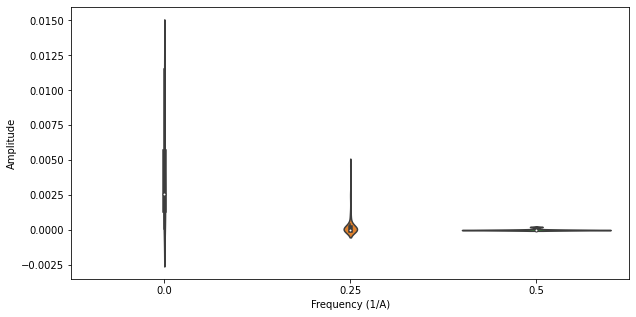

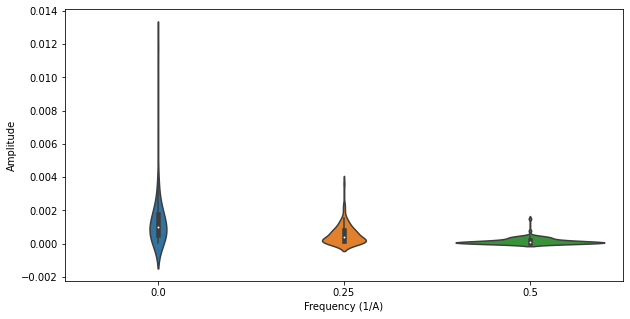

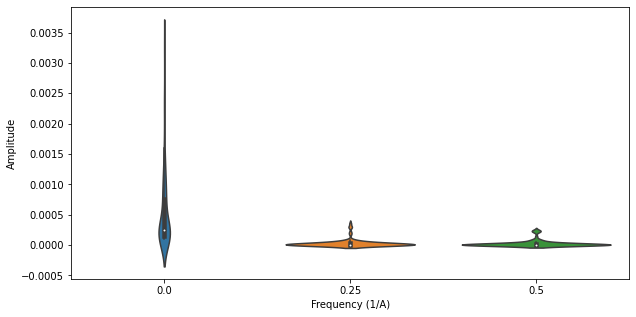

In [71]:
fig_scaled_orig_ref, ax_scaled_orig_ref = plot_amplitude_distribution(scaled_target_original_reference,3)
fig_orig_ref, ax_orig_ref = plot_amplitude_distribution(original_reference,3)
fig_target, ax_target = plot_amplitude_distribution(target,3)

  
